In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from google.colab import files
uploaded = files.upload()

Saving city_day.csv to city_day.csv


In [3]:
df = pd.read_csv("city_day.csv")

In [4]:
print(df.head())


        City        Date  PM2.5  PM10     NO    NO2    NOx  NH3     CO    SO2  \
0  Ahmedabad  2015-01-01    NaN   NaN   0.92  18.22  17.15  NaN   0.92  27.64   
1  Ahmedabad  2015-01-02    NaN   NaN   0.97  15.69  16.46  NaN   0.97  24.55   
2  Ahmedabad  2015-01-03    NaN   NaN  17.40  19.30  29.70  NaN  17.40  29.07   
3  Ahmedabad  2015-01-04    NaN   NaN   1.70  18.48  17.97  NaN   1.70  18.59   
4  Ahmedabad  2015-01-05    NaN   NaN  22.10  21.42  37.76  NaN  22.10  39.33   

       O3  Benzene  Toluene  Xylene  AQI AQI_Bucket  
0  133.36     0.00     0.02    0.00  NaN        NaN  
1   34.06     3.68     5.50    3.77  NaN        NaN  
2   30.70     6.80    16.40    2.25  NaN        NaN  
3   36.08     4.43    10.14    1.00  NaN        NaN  
4   39.31     7.01    18.89    2.78  NaN        NaN  


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   Date        29531 non-null  object 
 2   PM2.5       24933 non-null  float64
 3   PM10        18391 non-null  float64
 4   NO          25949 non-null  float64
 5   NO2         25946 non-null  float64
 6   NOx         25346 non-null  float64
 7   NH3         19203 non-null  float64
 8   CO          27472 non-null  float64
 9   SO2         25677 non-null  float64
 10  O3          25509 non-null  float64
 11  Benzene     23908 non-null  float64
 12  Toluene     21490 non-null  float64
 13  Xylene      11422 non-null  float64
 14  AQI         24850 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(3)
memory usage: 3.6+ MB
None


In [6]:
print(df.describe())


              PM2.5          PM10            NO           NO2           NOx  \
count  24933.000000  18391.000000  25949.000000  25946.000000  25346.000000   
mean      67.450578    118.127103     17.574730     28.560659     32.309123   
std       64.661449     90.605110     22.785846     24.474746     31.646011   
min        0.040000      0.010000      0.020000      0.010000      0.000000   
25%       28.820000     56.255000      5.630000     11.750000     12.820000   
50%       48.570000     95.680000      9.890000     21.690000     23.520000   
75%       80.590000    149.745000     19.950000     37.620000     40.127500   
max      949.990000   1000.000000    390.680000    362.210000    467.630000   

                NH3            CO           SO2            O3       Benzene  \
count  19203.000000  27472.000000  25677.000000  25509.000000  23908.000000   
mean      23.483476      2.248598     14.531977     34.491430      3.280840   
std       25.684275      6.962884     18.133775    

In [7]:
print(df.isnull().sum()) # See how many missing values per column

City              0
Date              0
PM2.5          4598
PM10          11140
NO             3582
NO2            3585
NOx            4185
NH3           10328
CO             2059
SO2            3854
O3             4022
Benzene        5623
Toluene        8041
Xylene        18109
AQI            4681
AQI_Bucket     4681
dtype: int64


In [8]:
df['Date'] = pd.to_datetime(df['Date']) #Convert 'date' column to datetime objects

In [9]:

initial_missing_percentage = (df.isnull().sum() / len(df)) * 100
print(initial_missing_percentage.sort_values(ascending=False))

Xylene        61.322001
PM10          37.723071
NH3           34.973418
Toluene       27.229014
Benzene       19.041008
AQI           15.851139
AQI_Bucket    15.851139
PM2.5         15.570079
NOx           14.171549
O3            13.619586
SO2           13.050692
NO2           12.139785
NO            12.129626
CO             6.972334
Date           0.000000
City           0.000000
dtype: float64


In [10]:
threshold = 60
cols_to_drop = initial_missing_percentage[initial_missing_percentage > threshold].index.tolist()


In [11]:
print(f"\n--- Dropping columns with >{threshold}% missing values: {cols_to_drop} ---")
df.drop(columns=cols_to_drop, inplace=True)


--- Dropping columns with >60% missing values: ['Xylene'] ---


In [12]:
# First, ensure data is sorted for proper time-series imputation
df.sort_values(by=['City', 'Date'], inplace=True)

In [13]:
# Identify numerical columns that still have missing values and need imputation
# Exclude 'City', 'Date', and 'AQI_Bucket' as they are not directly imputed in this manner.
# We'll handle AQI separately if needed, or if it's already imputed by its components.
impute_cols = df.select_dtypes(include=np.number).columns.tolist()

In [14]:
# Remove 'AQI' from direct imputation here, as it's often calculated from components.
# If AQI itself has missing values, we'll try to calculate it or interpolate separately later.
if 'AQI' in impute_cols:
    impute_cols.remove('AQI')

print(f"\n--- Imputing missing values for numerical columns: {impute_cols} ---")


--- Imputing missing values for numerical columns: ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene'] ---


In [15]:
#Set 'Date' column as the DataFrame's index
df.set_index('Date', inplace=True)

In [16]:
for col in impute_cols:
    if df[col].isnull().any(): # Only impute if there are actually missing values
        df[col] = df.groupby('City')[col].transform(lambda x: x.interpolate(method='time', limit_direction='both', limit_area='inside'))
        # Using 'time' method requires a datetime index or column for interpolation to work correctly.
        # 'limit_direction='both'' fills forward and backward
        # 'limit_area='inside'' ensures it only fills gaps between valid observations, not leading/trailing NaNs

        # After interpolation, there might still be leading/trailing NaNs for a city
        # if the entire series for that city starts/ends with NaNs.
        # We can try ffill/bfill for those remaining edge cases, or just drop rows if very few.
        df[col] = df.groupby('City')[col].transform(lambda x: x.ffill().bfill()) # Catch remaining NaNs at edges

In [17]:
# --- STEP 3: Handle AQI Missing Values ---
# AQI is often calculated from other pollutants. If it's missing but its components are present,
# we might be able to recalculate it or interpolate it based on its own time series.
print("\n--- Handling AQI Missing Values ---")
if 'AQI' in df.columns and df['AQI'].isnull().any():
    print("AQI still has missing values. Attempting interpolation.")
    df['AQI'] = df.groupby('City')['AQI'].transform(lambda x: x.interpolate(method='time', limit_direction='both', limit_area='inside'))
    df['AQI'] = df.groupby('City')['AQI'].transform(lambda x: x.ffill().bfill()) # Catch remaining NaNs at edges


--- Handling AQI Missing Values ---
AQI still has missing values. Attempting interpolation.


In [18]:
print("\n--- Final check for AQI missing values ---")
print(df['AQI'].isnull().sum())


--- Final check for AQI missing values ---
0


In [19]:
#Recreate AQI_Bucket based on updated AQI values
# (This part would follow if you have the get_aqi_bucket function defined)
def get_aqi_bucket(aqi_value):
    if 0. <= aqi_value <= 50.: return 'Good'
    elif 51. <= aqi_value <= 100.: return 'Satisfactory'
    elif 101. <= aqi_value <= 200.: return 'Moderate'
    elif 201. <= aqi_value <= 300.: return 'Poor'
    elif 301. <= aqi_value <= 400.: return 'Very Poor'
    elif aqi_value >= 401.: return 'Severe'
    else: return np.nan

In [20]:
if 'AQI' in df.columns:
    print("\n--- Recreating AQI_Bucket based on updated AQI values ---")
    df['AQI_Bucket'] = df['AQI'].apply(get_aqi_bucket)
    print("New AQI_Bucket value counts:\n", df['AQI_Bucket'].value_counts(dropna=False))


--- Recreating AQI_Bucket based on updated AQI values ---
New AQI_Bucket value counts:
 AQI_Bucket
Moderate        10164
Satisfactory    10109
Poor             3355
Very Poor        2807
Good             1566
Severe           1489
NaN                41
Name: count, dtype: int64


In [21]:
print("\n--- Final DataFrame Info After Cleaning and Imputation ---")
df.info()


--- Final DataFrame Info After Cleaning and Imputation ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29531 entries, 2015-01-01 to 2020-07-01
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   PM2.5       29531 non-null  float64
 2   PM10        27522 non-null  float64
 3   NO          29531 non-null  float64
 4   NO2         29531 non-null  float64
 5   NOx         28362 non-null  float64
 6   NH3         27522 non-null  float64
 7   CO          29531 non-null  float64
 8   SO2         29531 non-null  float64
 9   O3          29369 non-null  float64
 10  Benzene     26799 non-null  float64
 11  Toluene     25521 non-null  float64
 12  AQI         29531 non-null  float64
 13  AQI_Bucket  29490 non-null  object 
dtypes: float64(12), object(2)
memory usage: 3.4+ MB



--- Plotting Overall AQI Trend ---


/tmp/ipython-input-2012057308.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_aqi = df['AQI'].resample('M').mean()


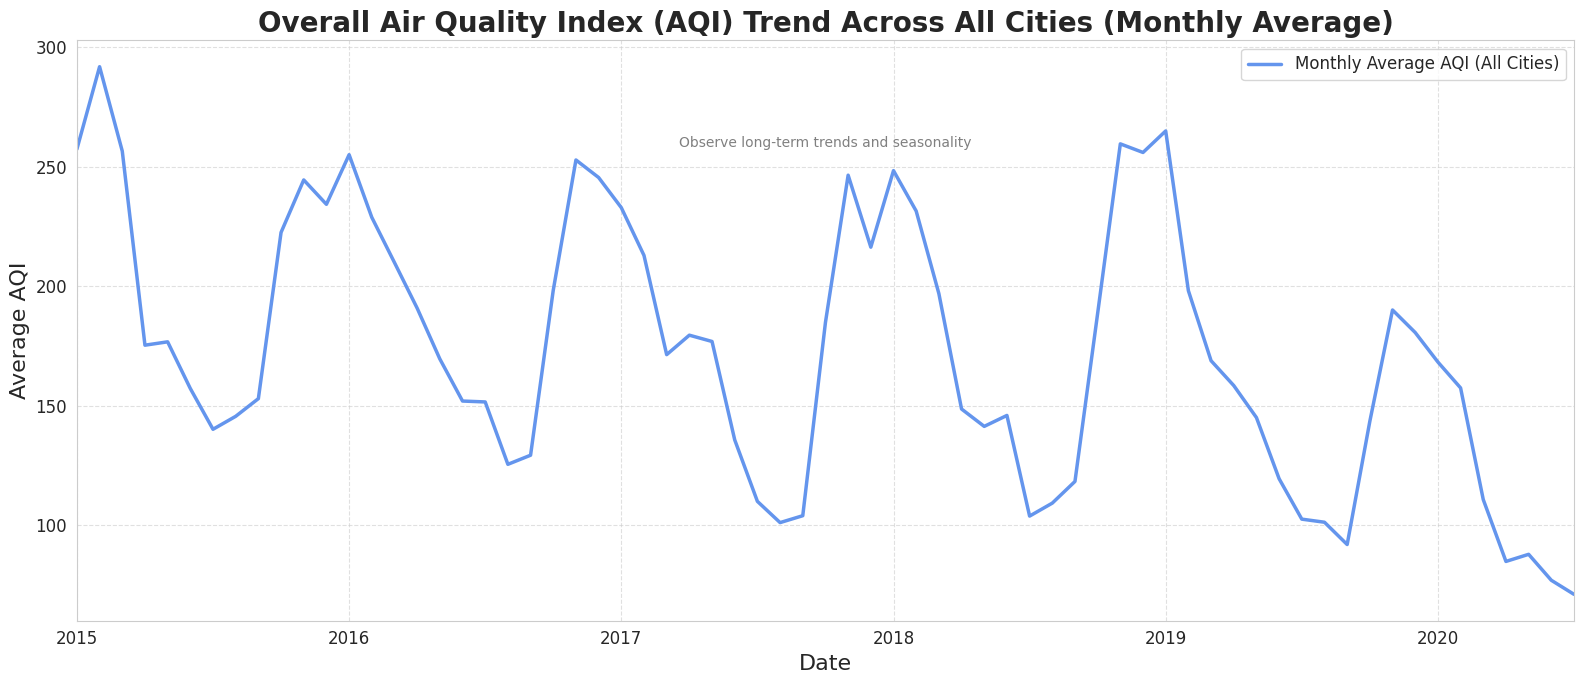

In [22]:
# Ensure default styles for beautiful plots
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12}) # Set a base font size for better readability

print("\n--- Plotting Overall AQI Trend ---")
plt.figure(figsize=(16, 7))

# Calculate monthly average AQI across all cities for a smoother trend
# Use .mean(axis=1) if you want to average across cities for each date,
# or if 'City' is still a column, you'd groupby index (Date) and then mean()
# Assuming 'Date' is the index, we can simply call .mean() after selecting AQI
monthly_avg_aqi = df['AQI'].resample('M').mean()

# Plotting the monthly average AQI
monthly_avg_aqi.plot(linewidth=2.5, color='cornflowerblue', label='Monthly Average AQI (All Cities)')

plt.title('Overall Air Quality Index (AQI) Trend Across All Cities (Monthly Average)', fontsize=20, weight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Average AQI', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

# Adding a subtle annotation for context (Woww Factor)
plt.text(monthly_avg_aqi.index[len(monthly_avg_aqi)//2], monthly_avg_aqi.max() * 0.9,
         'Observe long-term trends and seasonality',
         fontsize=10, color='gray', ha='center', va='top')

plt.tight_layout()
plt.show()


--- Visualizing Average AQI by City (Top/Bottom) ---


/tmp/ipython-input-3138440494.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cities.index, y=top_cities.values, palette='Reds_d') # Reds for more polluted


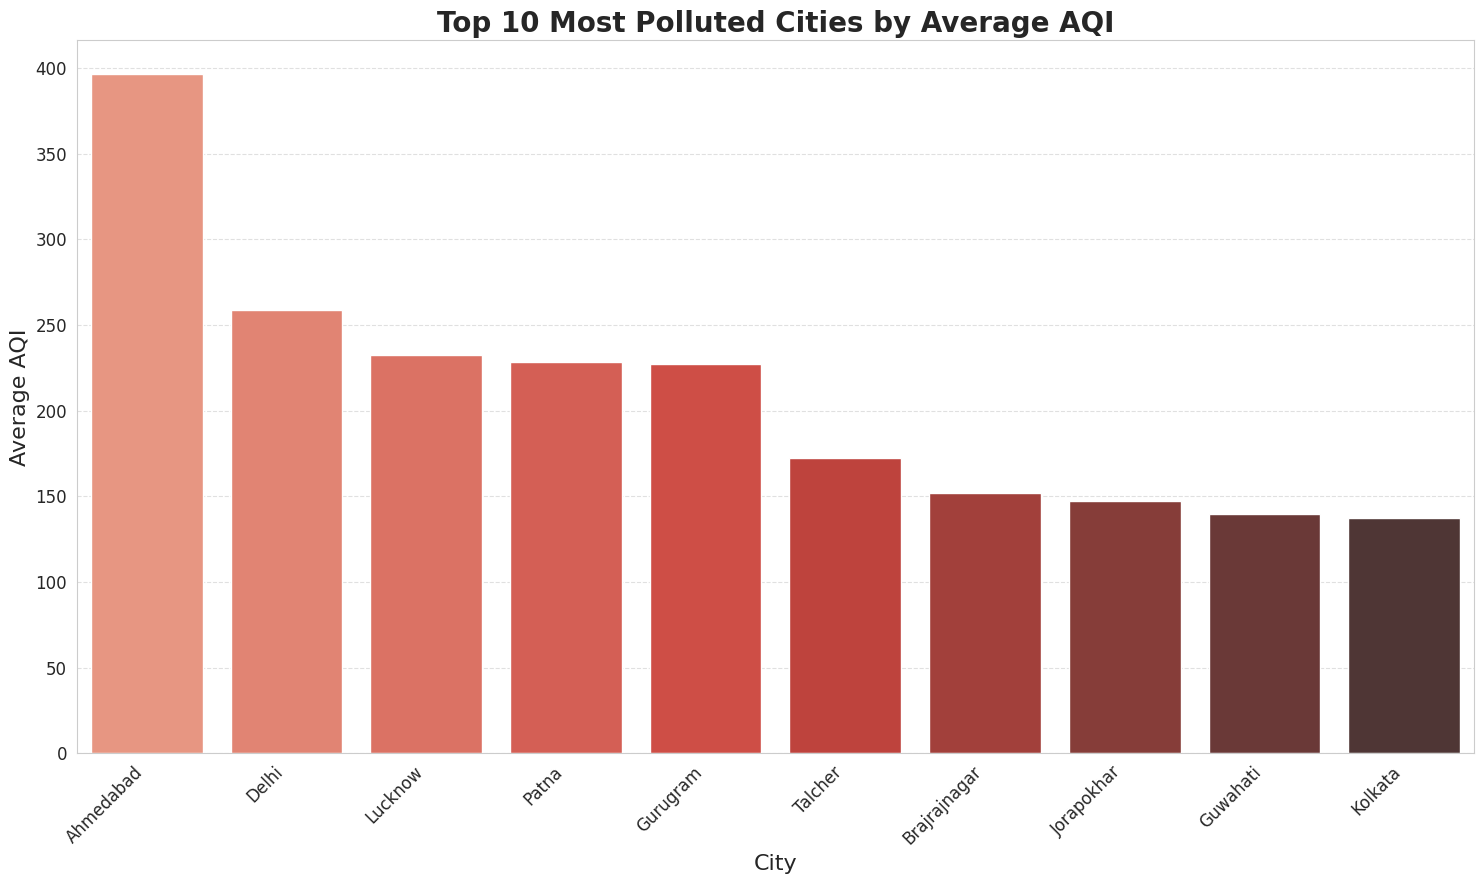

/tmp/ipython-input-3138440494.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bottom_cities.index, y=bottom_cities.values, palette='Greens_d') # Greens for less polluted


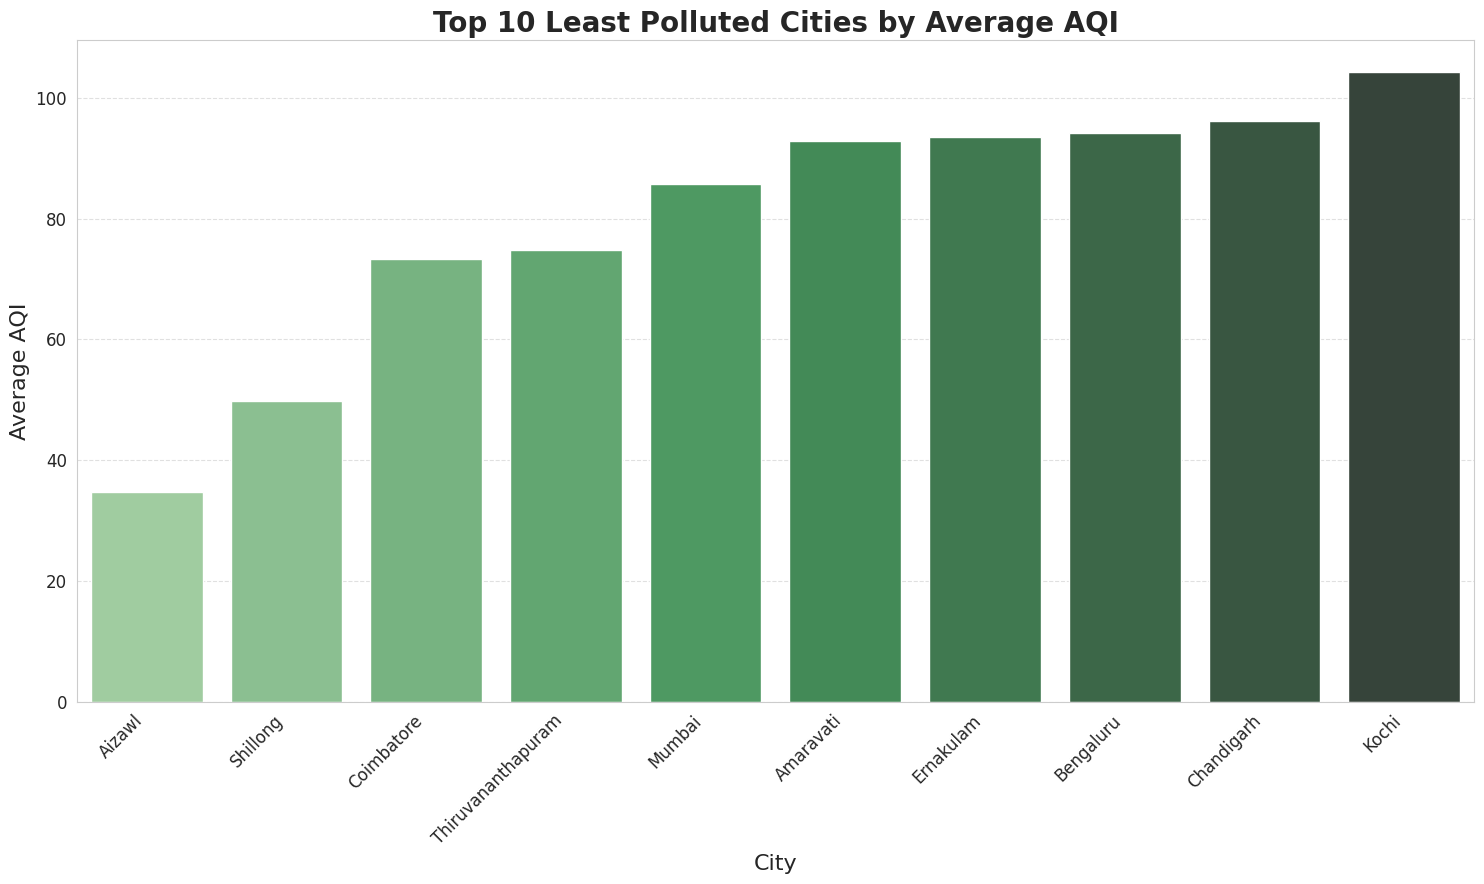


--- Top 5 Most Polluted Cities (Average AQI) ---
City
Ahmedabad    396.402937
Delhi        258.621453
Lucknow      232.348183
Patna        228.524758
Gurugram     227.107802
Name: AQI, dtype: float64

--- Top 5 Least Polluted Cities (Average AQI) ---
City
Mumbai                85.749876
Thiruvananthapuram    74.732014
Coimbatore            73.343264
Shillong              49.798387
Aizawl                34.778761
Name: AQI, dtype: float64


In [23]:
print("\n--- Visualizing Average AQI by City (Top/Bottom) ---")

# If 'City' is still a regular column (not part of a MultiIndex, which is likely)
df_reset = df.reset_index() # Temporarily reset index to treat 'Date' and 'City' as columns

avg_aqi_by_city = df_reset.groupby('City')['AQI'].mean().sort_values(ascending=False)

plt.figure(figsize=(15, 9))

# Selecting top 10 and bottom 10 for better visualization if many cities
num_cities_to_show = 10
top_cities = avg_aqi_by_city.head(num_cities_to_show)
bottom_cities = avg_aqi_by_city.tail(num_cities_to_show).sort_values(ascending=True) # Sort bottom in ascending for clearer visual

# Combine for a divergent color map if desired, or plot separately
# For now, let's just plot top N for clarity, you can create a second plot for bottom N

sns.barplot(x=top_cities.index, y=top_cities.values, palette='Reds_d') # Reds for more polluted
plt.title(f'Top {num_cities_to_show} Most Polluted Cities by Average AQI', fontsize=20, weight='bold')
plt.xlabel('City', fontsize=16)
plt.ylabel('Average AQI', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12) # Rotate labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 9))
sns.barplot(x=bottom_cities.index, y=bottom_cities.values, palette='Greens_d') # Greens for less polluted
plt.title(f'Top {num_cities_to_show} Least Polluted Cities by Average AQI', fontsize=20, weight='bold')
plt.xlabel('City', fontsize=16)
plt.ylabel('Average AQI', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


print("\n--- Top 5 Most Polluted Cities (Average AQI) ---")
print(avg_aqi_by_city.head(5))

print("\n--- Top 5 Least Polluted Cities (Average AQI) ---")
print(avg_aqi_by_city.tail(5))


--- Distribution of AQI Buckets ---


/tmp/ipython-input-1928686517.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_reset, x='AQI_Bucket', order=aqi_bucket_order, palette=aqi_colors, edgecolor='black', linewidth=0.5)


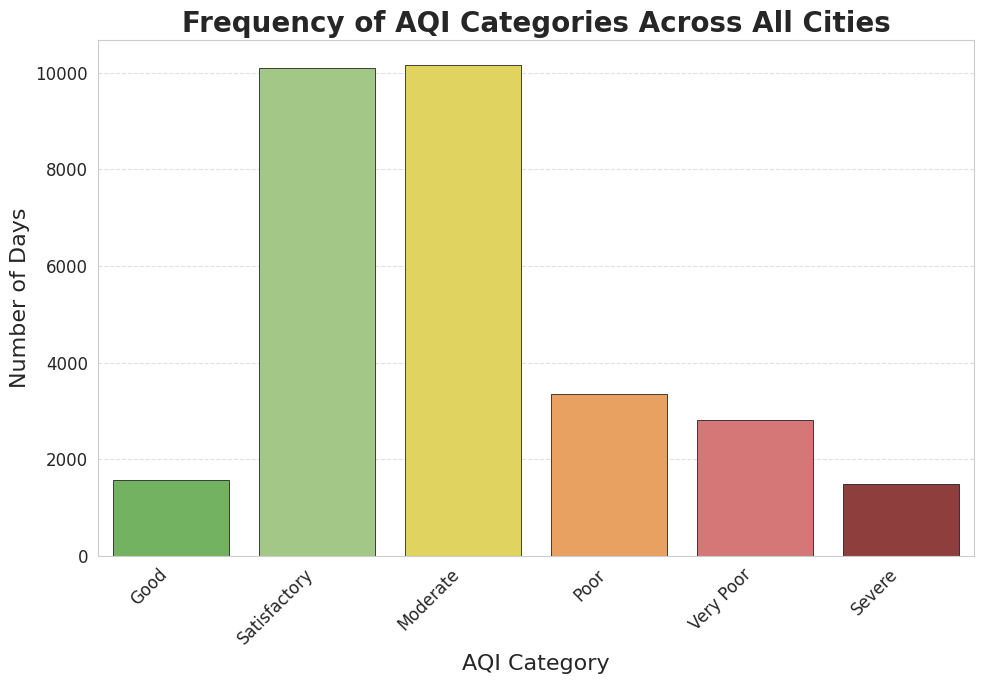

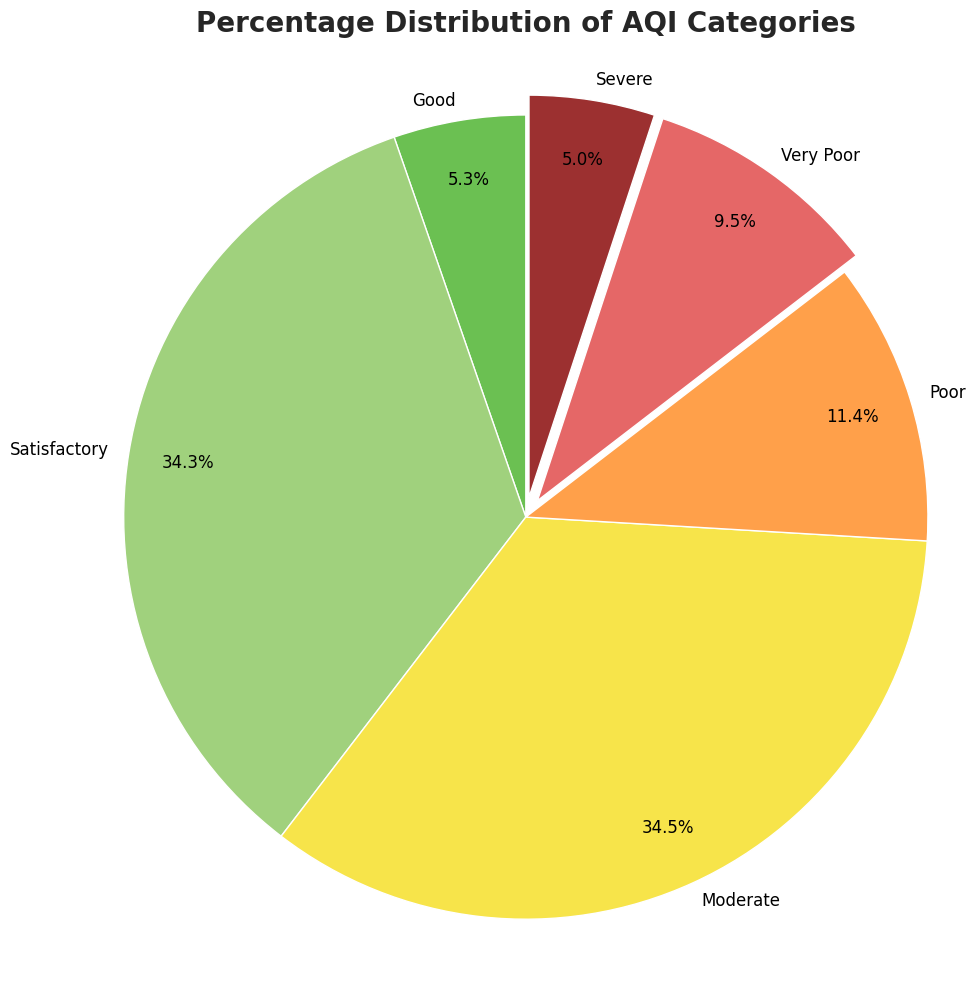

In [24]:
print("\n--- Distribution of AQI Buckets ---")
plt.figure(figsize=(10, 7))

# Define a consistent order for buckets
aqi_bucket_order = ['Good', 'Satisfactory', 'Moderate', 'Poor', 'Very Poor', 'Severe']

# Define a color palette that makes sense for pollution severity
aqi_colors = {
    'Good': '#6bc052',         # Green
    'Satisfactory': '#a0d17d', # Lighter Green
    'Moderate': '#f7e44a',     # Yellow
    'Poor': '#ffa04a',         # Orange
    'Very Poor': '#e56767',    # Red
    'Severe': '#9c3030'        # Darker Red
}

# Use df_reset from previous step, or reset index if you haven't.
# df_reset = df.reset_index() # Uncomment if you didn't run it above

# Count plot (shows absolute counts)
sns.countplot(data=df_reset, x='AQI_Bucket', order=aqi_bucket_order, palette=aqi_colors, edgecolor='black', linewidth=0.5)
plt.title('Frequency of AQI Categories Across All Cities', fontsize=20, weight='bold')
plt.xlabel('AQI Category', fontsize=16)
plt.ylabel('Number of Days', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Pie chart (shows percentages - great for "woww" as it's immediately digestible)
plt.figure(figsize=(10, 10))
aqi_bucket_counts = df_reset['AQI_Bucket'].value_counts(normalize=True).reindex(aqi_bucket_order).dropna() * 100

# Ensure consistent colors for pie chart
pie_colors = [aqi_colors.get(bucket, 'gray') for bucket in aqi_bucket_counts.index]

plt.pie(aqi_bucket_counts, labels=aqi_bucket_counts.index, autopct='%1.1f%%', startangle=90,
        colors=pie_colors,
        explode=[0.05 if bucket in ['Very Poor', 'Severe'] else 0 for bucket in aqi_bucket_counts.index], # Explode severe categories
        pctdistance=0.85, labeldistance=1.05, textprops={'fontsize': 12, 'color': 'black'})

plt.title('Percentage Distribution of AQI Categories', fontsize=20, weight='bold')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()


--- Seasonal Variation of AQI by Month (Box Plots) ---


/tmp/ipython-input-3418832354.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_reset, x='Month', y='AQI', palette='magma') # Magma or plasma often work well for heat maps/severity


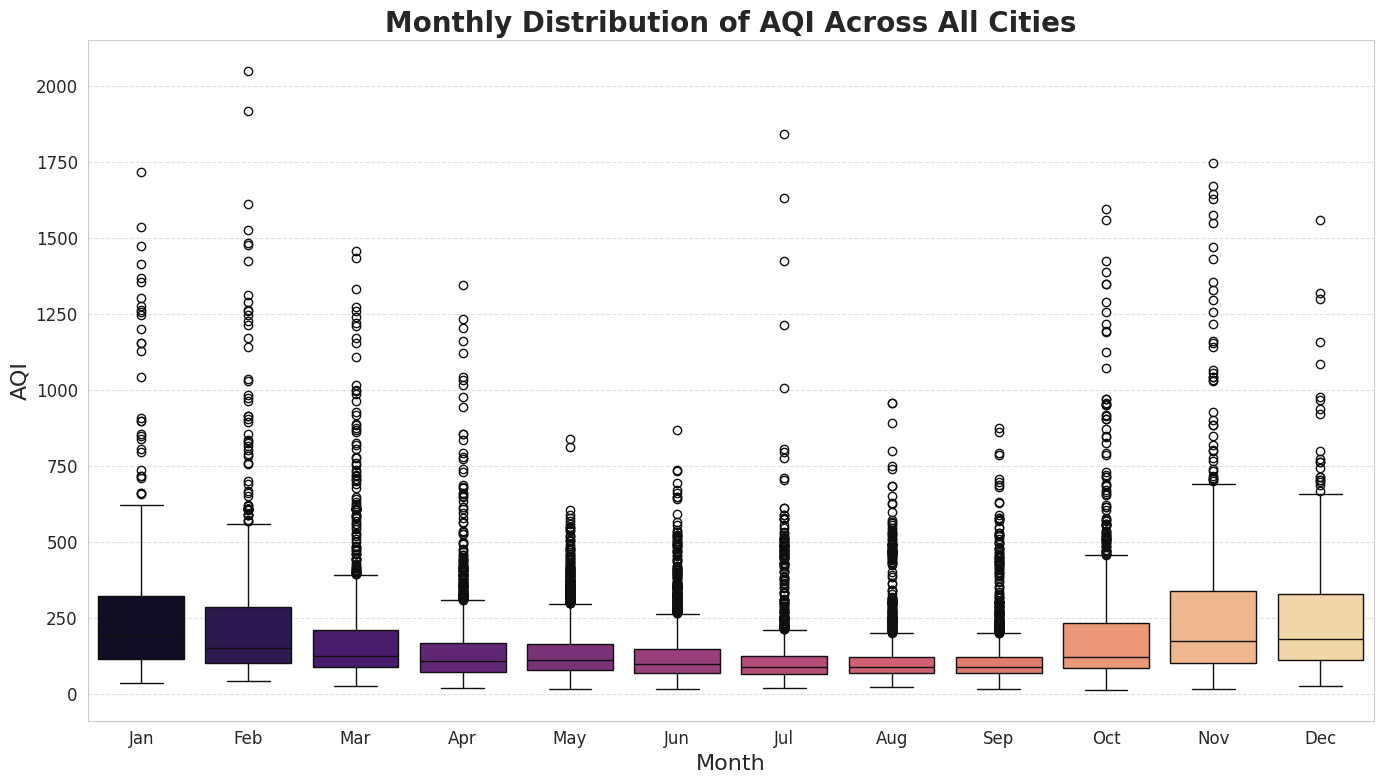

/tmp/ipython-input-3418832354.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_reset, x='Month', y='PM2.5', palette='crest')


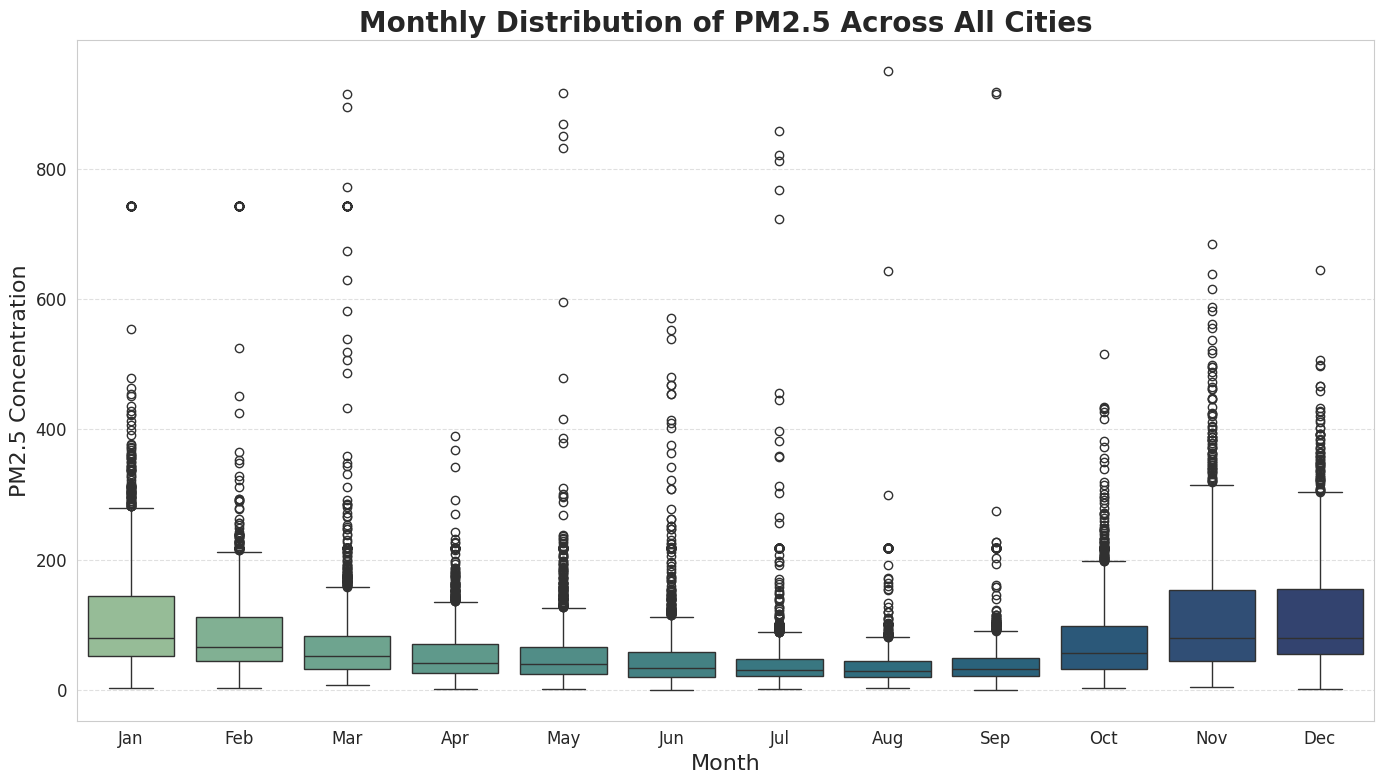

In [25]:
print("\n--- Seasonal Variation of AQI by Month (Box Plots) ---")

# Create 'Month' column (if not already present and if df_reset is used)
# If df has 'Date' as index, df.index.month will work.
if 'Month' not in df_reset.columns:
    df_reset['Month'] = df_reset['Date'].dt.month

plt.figure(figsize=(14, 8))
sns.boxplot(data=df_reset, x='Month', y='AQI', palette='magma') # Magma or plasma often work well for heat maps/severity

plt.title('Monthly Distribution of AQI Across All Cities', fontsize=20, weight='bold')
plt.xlabel('Month', fontsize=16)
plt.ylabel('AQI', fontsize=16)
plt.xticks(ticks=range(0,12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# You can repeat this for specific pollutants like PM2.5 and PM10
plt.figure(figsize=(14, 8))
sns.boxplot(data=df_reset, x='Month', y='PM2.5', palette='crest')
plt.title('Monthly Distribution of PM2.5 Across All Cities', fontsize=20, weight='bold')
plt.xlabel('Month', fontsize=16)
plt.ylabel('PM2.5 Concentration', fontsize=16)
plt.xticks(ticks=range(0,12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [26]:
print("\n--- Plotting Correlation Heatmap of Pollution Parameters ---")

# Select only the numerical pollution columns for correlation analysis.
# Exclude 'AQI_Bucket' as it's categorical.
# Keep 'AQI' as it's a key outcome to see how other pollutants correlate with it.

# First, make sure 'City' is not part of the index if you plan to drop it later for correlation matrix
# If df.reset_index() was used earlier and df_reset is available, use df_reset.
# Otherwise, if df still has 'Date' as index and 'City' as a column:

# Temporarily reset index to treat 'Date' as a column for easier numeric selection if it's the index
# (or make sure your df_reset from previous steps is used)
df_temp = df.copy().reset_index() # Create a temporary copy to ensure 'City' and 'Date' are columns for this step


--- Plotting Correlation Heatmap of Pollution Parameters ---


In [27]:
# Identify all numerical columns relevant for correlation
numeric_cols_for_corr = df_temp.select_dtypes(include=np.number).columns.tolist()


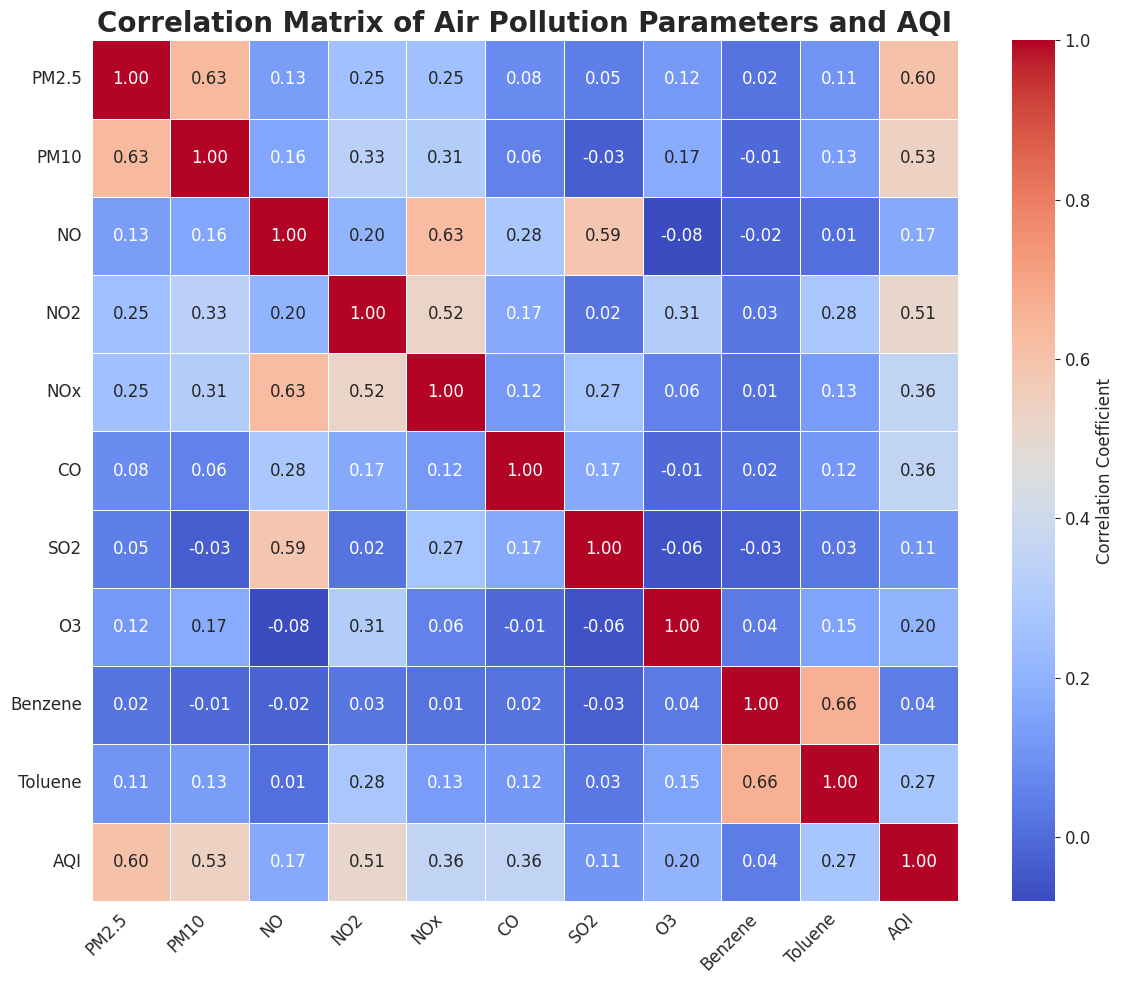


--- Highly Correlated Pollution Parameters (Absolute Correlation > 0.7) ---
Series([], dtype: float64)


In [28]:
pollution_params = [
    'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'AQI'
]
# Filter to only include columns that actually exist in your DataFrame
actual_pollution_cols = [col for col in pollution_params if col in df_temp.columns]

# Calculate the correlation matrix
correlation_matrix = df_temp[actual_pollution_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,        # Show the correlation values on the heatmap
    cmap='coolwarm',   # Diverging colormap: red for negative, blue for positive
    fmt=".2f",         # Format annotation to 2 decimal places
    linewidths=.5,     # Add lines between cells for better separation
    cbar_kws={'label': 'Correlation Coefficient'} # Label the color bar
)
plt.title('Correlation Matrix of Air Pollution Parameters and AQI', fontsize=20, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12) # Keep y-labels horizontal
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

# Optional: Print out highly correlated pairs (e.g., abs correlation > 0.7)
print("\n--- Highly Correlated Pollution Parameters (Absolute Correlation > 0.7) ---")

# Get pairs with high correlation
# We use unstack to convert the matrix to a Series of pairs, then drop self-correlations and duplicates
corr_pairs = correlation_matrix.unstack().sort_values(kind="quicksort", ascending=False)

# Filter for unique pairs with abs correlation > 0.7 (excluding self-correlation of 1.0)
strong_corr_pairs = corr_pairs[(corr_pairs.abs() > 0.7) & (corr_pairs != 1.0)]
print(strong_corr_pairs)

In [29]:
!pip install plotly

In [30]:
if 'Year' not in df_reset.columns: # Often useful for interactive plots
    df_reset['Year'] = df_reset['Date'].dt.year

print("--- Starting Interactive Visualizations with Plotly Express ---")

--- Starting Interactive Visualizations with Plotly Express ---


In [31]:
import plotly.express as px
import plotly.graph_objects as go

In [32]:
print("\n--- Interactive Plot: Overall AQI Trend (Monthly Average) ---")

# Calculate monthly average AQI across all cities
# Group by Date (now a column in df_reset), then resample
monthly_avg_aqi_df = df_reset.groupby('Date')['AQI'].mean().reset_index()
monthly_avg_aqi_resampled = monthly_avg_aqi_df.set_index('Date').resample('M').mean().reset_index()

fig = px.line(
    monthly_avg_aqi_resampled,
    x='Date',
    y='AQI',
    title='Interactive: Overall Air Quality Index (AQI) Trend Across All Cities (Monthly Average)',
    labels={'AQI': 'Average AQI'},
    line_shape='linear', # or 'spline' for smoother lines
    template='plotly_white' # or 'plotly_dark'
)

fig.update_traces(line=dict(width=2.5, color='cornflowerblue'))
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Average AQI',
    font=dict(size=12),
    title_font_size=18,
    hovermode='x unified' # Shows hover data for all traces at a given x-position
)

fig.show()


--- Interactive Plot: Overall AQI Trend (Monthly Average) ---


/tmp/ipython-input-905017170.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_aqi_resampled = monthly_avg_aqi_df.set_index('Date').resample('M').mean().reset_index()


In [33]:
print("\n--- Interactive Plot: AQI Trends for Selected Cities ---")

# Re-select your cities to compare based on your data analysis
cities_to_compare = ['Delhi', 'Bengaluru', 'Chennai'] # Adjust these based on your data's actual top/bottom cities

# Filter data for selected cities
filtered_df = df_reset[df_reset['City'].isin(cities_to_compare)]

# Calculate rolling average within the filtered data, grouping by city
# Plotly can handle this internally with transformations or you pre-calculate it
# Let's pre-calculate for clarity.
# Ensure 'Date' is sorted for rolling average calculation
filtered_df_sorted = filtered_df.sort_values(by=['City', 'Date'])
filtered_df_sorted['Rolling_Avg_AQI'] = filtered_df_sorted.groupby('City')['AQI'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())


fig = px.line(
    filtered_df_sorted,
    x='Date',
    y='AQI',
    color='City',
    line_dash_map={'Daily AQI': 'dot', 'Rolling Avg AQI': 'solid'}, # Define line styles
    line_group='City', # Group lines by city
    hover_name='City', # Show city name on hover
    title='Interactive: AQI Trends and 30-Day Rolling Averages for Selected Cities',
    labels={'AQI': 'AQI Value'},
    template='plotly_white'
)

# Add rolling average lines separately, or modify above to include a 'type' column
# For cleaner code and separate legends, it's often better to add them as separate traces
for city in cities_to_compare:
    city_data = filtered_df_sorted[filtered_df_sorted['City'] == city]
    fig.add_trace(go.Scatter(
        x=city_data['Date'],
        y=city_data['Rolling_Avg_AQI'],
        mode='lines',
        name=f'{city} (30-Day Rolling Avg)',
        line=dict(width=3),
        hovertemplate=f'<b>City:</b> {city}<br><b>Date:</b> %{{x|%Y-%m-%d}}<br><b>Rolling Avg AQI:</b> %{{y:.2f}}<extra></extra>'
    ))

    # Update existing traces for daily AQI to just be lines and rename
    fig.update_traces(selector=dict(name=city), mode='lines', line=dict(width=1), name=f'{city} (Daily AQI)',
                      hovertemplate=f'<b>City:</b> {city}<br><b>Date:</b> %{{x|%Y-%m-%d}}<br><b>Daily AQI:</b> %{{y}}<extra></extra>')


fig.update_layout(
    xaxis_title='Date',
    yaxis_title='AQI',
    font=dict(size=12),
    title_font_size=18,
    hovermode='x unified' # Allows hovering across all lines at a given date
)

fig.show()


--- Interactive Plot: AQI Trends for Selected Cities ---
